<a href="https://colab.research.google.com/github/jundev1l2l/archive/blob/main/RL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../")

matplotlib.style.use('ggplot')

## Environment

In [ ]:
class GridWorld:
    def __init__(self, rewards, terminals):
        self.rewards = rewards
        self.terminals = terminals
        self.state_space = rewards.shape
        self.nR, self.nC = rewards.shape
        self.action_space = [0,1,2,3]
        self.nA = len(self.action_space) # number of actions = 4

    def reset(self):
        # exploring start
        nR, nC = self.state_space
        initial_state = (np.random.randint(nR), np.random.randint(nC))
        self.state = initial_state
        return initial_state

    def step(self, action):
        state = self.state
        if action == 0: # up
            next_state = (state[0] - 1, state[1])
        elif action == 1: # down
            next_state = (state[0] + 1, state[1])
        elif action == 2: # left
            next_state = (state[0], state[1] - 1)
        else: # right
            next_state = (state[0], state[1] + 1)
        # whether next state is legal
        is_legal = True if ((next_state[0] >= 0) and (next_state[0] <= (self.nR -1)) and (next_state[1] >= 0) and (next_state[1] <= (self.nC -1))) else False
        if is_legal:
            # update state
            self.state = next_state
            # whether next state is terminal
            is_end = True if self.terminals[next_state[0], next_state[1]] == 1 else False
            # reward
            reward = self.rewards[next_state[0], next_state[1]]
        else:
            is_end = None
            reward = None

        return next_state, reward, is_legal, is_end

## Random, Greedy, Epsilon-Greedy Policy

In [ ]:
def random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    pi = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return pi
    return policy_fn

In [ ]:
def greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        pi = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        pi[best_action] = 1.0
        return pi
    return policy_fn

In [ ]:
def epsilon_greedy_policy(Q, epsilon=0.1):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    def policy_fn(state):
        nA = len(Q[state])
        pi = np.zeros_like(Q[state], dtype=float) + epsilon / nA
        best_action = np.argmax(Q[state])
        pi[best_action] += (1 - epsilon)
        return pi
    return policy_fn

## Off-policy MC control

In [ ]:
def mc_control_train(env, num_episodes, num_epochs=100, num_test=0, discount_factor=1.0, epsilon=0.1):

    # action-value function
    Q = defaultdict(lambda: np.zeros(env.nA))
    # denominator of the importance sampling formula
    C = defaultdict(lambda: np.zeros(env.nA))

    target_policy = greedy_policy(Q)
    behavior_policy = epsilon_greedy_policy(Q, epsilon)
    mean_rewards = []

    for i in range(num_episodes):
        if i % 1000 == 999:
            print("\rEpisode {}/{}.".format(i+1, num_episodes), end="")
            sys.stdout.flush()

        ### Generate an episode.
        episode = []
        state = env.reset()
        t = 0
        while (t <= num_epochs):
            # sample an action from behavior policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, is_legal, is_end = env.step(action)
            # whether the new state is possible in the environment
            if is_legal:
                episode.append((state, action, reward))
                state = next_state
                t += 1
            # termination
            if is_end:
                break

        ### Update Q function
        G = 0.0  # return
        W = 1.0  # importance sampling ratio
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1. / behavior_policy(state)[action]

        ### evlauation
        if num_test > 0:
            mean_reward = mc_control_test(env, target_policy, num_epochs, num_test)
            mean_rewards.append(mean_reward)
            
    V = defaultdict(float)  # value function
    for state, action_values in Q.items():
        action_value = np.max(action_values)
        V[state] = action_value
        
    return Q, V, target_policy, mean_rewards

In [ ]:
def mc_control_test(env, policy, num_epochs=100, num_test=10):

    # list of reward history
    mean_reward = 0
        
    for i in range(1, num_test + 1):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        state = env.reset()

        k = 0
        while (k <= num_epochs):
            # Sample an action from our policy
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, is_legal, is_end = env.step(action)
            if is_legal:
                state = next_state
                mean_reward += reward / num_test
            k += 1
            if is_end:
                break

    return mean_reward

### Train and Evaluate

In [ ]:
rewards = np.array([[-1,-1,-1,+100],
                    [-1,-1,-1,-1],
                    [-1,-1,-1,-1],
                    [-1,-1,-1,-1]])
terminals = np.array([[0,0,0,1],
                      [0,0,0,0],
                      [0,0,0,0],
                      [0,0,0,0]])
env = GridWorld(rewards, terminals)

num_episodes = 500
num_epochs = 100
num_test = 10
discount_factor = 1.0
epsilon = 0.1

Q, V, policy, mean_rewards = mc_control_train(env, num_episodes=num_episodes, num_epochs=num_epochs, num_test=num_test, discount_factor=discount_factor, epsilon=epsilon)
print(f"\rFinished")

Finished


In [ ]:
print(rewards)

[[ -1  -1  -1 100]
 [ -1  -1  -1  -1]
 [ -1  -1  -1  -1]
 [ -1  -1  -1  -1]]


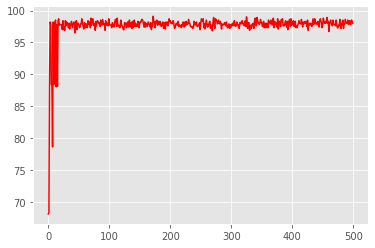

In [ ]:
plt.plot(np.arange(num_episodes)[:500], mean_rewards[:500], "r-")

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    S = V.keys()  # state space
    min_x = min(k[0] for k in S)
    max_x = max(k[0] for k in S)
    min_y = min(k[1] for k in S)
    max_y = max(k[1] for k in S)

    # x_range = np.arange(min_x, max_x + 1)
    # y_range = np.arange(min_y, max_y + 1)
    # X, Y = np.meshgrid(x_range, y_range)

    X, Y, Z = [], [], []
    for s in S:
        x, y = s
        z = V[s]
        X.append(x)
        Y.append(y)
        Z.append(z)
    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)
    Z = np.array(Z).reshape(-1,1)

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.scatter(X, Y, Z, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=10.0)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, "{}".format(title))

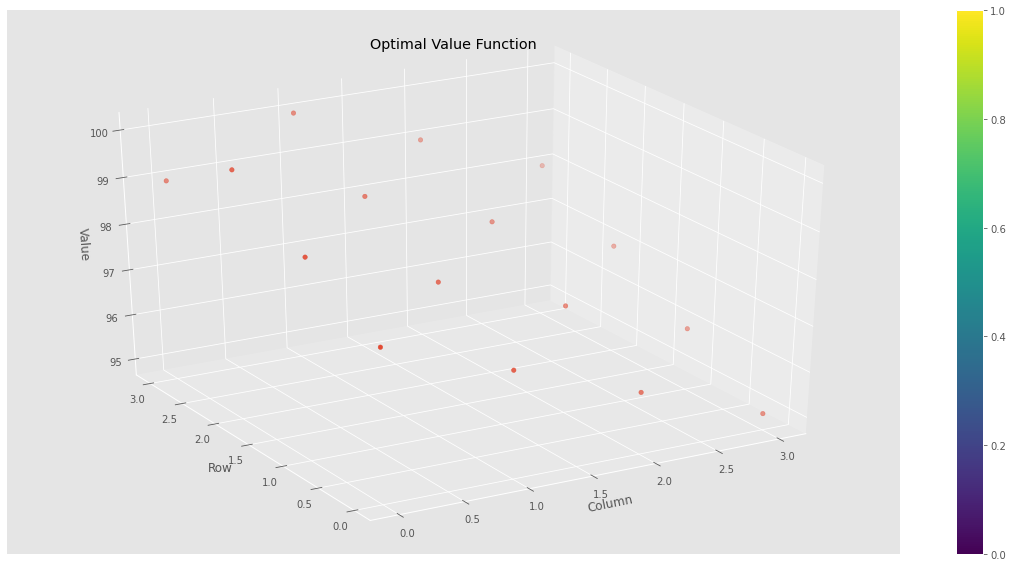

In [ ]:
# For plotting: Create value function from action-value function
# by picking the best action at each state

plot_value_function(V, title="Optimal Value Function")

## SARSA (On-policy TD control)

In [ ]:
def sarsa_train(env, num_episodes, num_epochs, discount_factor=1.0, epsilon=0.1, alpha=0.5):

    # action-value function
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    rewards_list = []
    lengths_list = []
    for i in range(num_episodes):
        if i % 1000 == 999:
            print("\rEpisode {}/{}.".format(i + 1, num_episodes), end="")
            sys.stdout.flush()
        
        ### Generate an episode
        state = env.reset()
        total_reward = 0
        t = 0
        while True:
            t += 1
            # Sample an action with the policy
            policy = epsilon_greedy_policy(Q, epsilon)
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, is_legal, is_end = env.step(action)
            
            if is_legal:
                next_probs = policy(next_state)
                next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
                total_reward += reward
            
                # TD Update
                td_target = reward + discount_factor * Q[next_state][next_action]
                td_delta = td_target - Q[state][action]
                Q[state][action] += alpha * td_delta

                action = next_action
                state = next_state

            if is_end or (t == num_epochs + 1):
                break
        
        rewards_list.append(total_reward)
        lengths_list.append(t)
    
    return Q, rewards_list, lengths_list

In [ ]:
rewards = np.array([[-1,-1,-1,+100],
                    [-1,-1,-1,-1],
                    [-1,-1,-1,-1],
                    [-1,-1,-1,-1]])
terminals = np.array([[0,0,0,1],
                      [0,0,0,0],
                      [0,0,0,0],
                      [0,0,0,0]])
env = GridWorld(rewards, terminals)

num_episodes = 500
num_epochs = 1000
discount_factor = 1.0
epsilon = 0.1
alpha = 0.5

Q, rewards_list, lengths_list = sarsa_train(env, num_episodes=num_episodes, num_epochs=num_epochs, discount_factor=discount_factor, epsilon=epsilon, alpha=alpha)
print(f"\rFinished")

Finished


In [ ]:
rewards_array = np.array(rewards_list)
window_size = 1

smoothed_rewards = [rewards_array[window_size*i:window_size*(i+1)].mean() for i in range(int(num_episodes / window_size))]

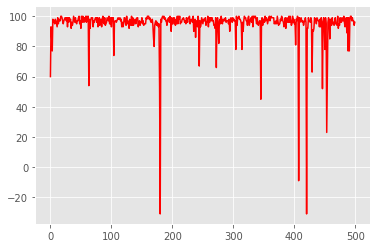

In [ ]:
plt.plot(np.arange(len(smoothed_rewards)), smoothed_rewards, "r-")

In [ ]:
lengths_array = np.array(lengths_list)
window_size = 1

smoothed_lengths = [lengths_array[window_size*i:window_size*(i+1)].mean() for i in range(int(num_episodes / window_size))]

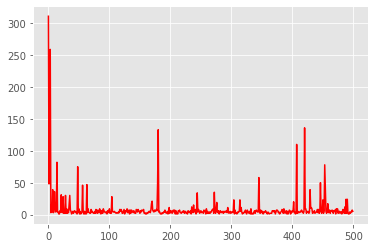

In [ ]:
plt.plot(np.arange(len(smoothed_lengths)), smoothed_lengths, "r-")

## Q-Learning (Off-policy TD control)

In [ ]:
def q_learning_train(env, num_episodes, num_epochs, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # action-value function
    Q = defaultdict(lambda: np.zeros(env.nA))

    rewards_list = []
    lengths_list = []
    
    for i in range(num_episodes):
        if i % 1000 == 999:
            print("\rEpisode {}/{}.".format(i + 1, num_episodes), end="")
            sys.stdout.flush()
        
        ### Generate an episode
        state = env.reset()
        total_reward = 0
        t = 0
        while True:
            t += 1

            # Sample an action from our policy
            policy = epsilon_greedy_policy(Q, epsilon)
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, is_legal, is_end = env.step(action)

            if is_legal:
            
                # TD Update
                best_next_action = np.argmax(Q[next_state])    
                td_target = reward + discount_factor * Q[next_state][best_next_action]
                td_delta = td_target - Q[state][action]
                Q[state][action] += alpha * td_delta

                total_reward += reward
                state = next_state
                
            if is_end or (t == num_epochs + 1):
                break
        
        rewards_list.append(total_reward)
        lengths_list.append(t)
    
    return Q, rewards_list, lengths_list

In [ ]:
rewards = np.array([[-1,-1,-1,+100],
                    [-1,-1,-1,-1],
                    [-1,-1,-1,-1],
                    [-1,-1,-1,-1]])
terminals = np.array([[0,0,0,1],
                      [0,0,0,0],
                      [0,0,0,0],
                      [0,0,0,0]])
env = GridWorld(rewards, terminals)

num_episodes = 500
num_epochs = 1000
discount_factor = 1.0
epsilon = 0.1
alpha = 0.5

Q, rewards_list, lengths_list = q_learning_train(env, num_episodes=num_episodes, num_epochs=num_epochs, discount_factor=discount_factor, epsilon=epsilon, alpha=alpha)
print(f"\rFinished")

Finished


In [ ]:
rewards_array = np.array(rewards_list)
window_size = 1

smoothed_rewards = [rewards_array[window_size*i:window_size*(i+1)].mean() for i in range(int(num_episodes / window_size))]

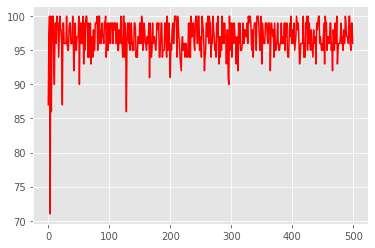

In [ ]:
plt.plot(np.arange(len(smoothed_rewards)), smoothed_rewards, "r-")

In [ ]:
lengths_array = np.array(lengths_list)
window_size = 1

smoothed_lengths = [lengths_array[window_size*i:window_size*(i+1)].mean() for i in range(int(num_episodes / window_size))]

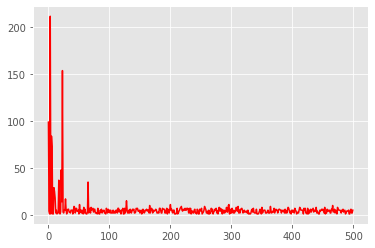

In [ ]:
plt.plot(np.arange(len(smoothed_lengths)), smoothed_lengths, "r-")